# 目次

- データ確認
- 目的変数との関係性を可視化
- 原系列の可視化
- データ準備
- ADF検定処理
  1. 差分変換
  2. 対数変換
  3. 対数差分変換
  4. 季節差分変換
  5. ラグ１の差分を取る
- 周期性の確認
  1. 成分分解
  2. コレログラム
- 前処理後のデータで再確認

# ライブラリ群

In [43]:
# データ処理
import csv
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.0f}'.format

# 描画
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
import japanize_matplotlib
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style(style='dark')
from tqdm import tqdm # プログレスバー
mplstyle.use('fast')

# 表示調整
from matplotlib import rcParams
# スタイル・フォントの調整
plt.style.use('ggplot') 
font = {'family' : 'meiryo'}
plt.rc('font', **font)
rcParams['font.family'] = 'sans-serif'
# 日本語対応
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'Noto Sans CJK JP']
plt.rcParams["figure.figsize"] = [20,5] # 表示サイズ
plt.rcParams["font.size"] = 10 # 文字サイズ
# HTML対応
from IPython.core.display import display, HTML
# 全表示対応
display(HTML("<style>.cm-s-ipython span.cm-comment { color: blue; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# データ確認

In [44]:
stock_df = pd.read_csv("./Tesla.csv")

In [45]:
stock_df.shape
stock_df.head().astype(str)
stock_df.tail().astype(str)

(1692, 7)

,Date,Open,High,Low,Close,Volume,Adj_Close
0,6/29/2010,19.0,25.0,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.83,17187100,23.83
2,7/1/2010,25.0,25.92,20.27,21.959999,8218800,21.959999
3,7/2/2010,23.0,23.1,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.0,20.0,15.83,16.110001,6866900,16.110001


,Date,Open,High,Low,Close,Volume,Adj_Close
1687,3/13/2017,244.82000699999998,246.850006,242.77999900000003,246.169998,3010700,246.169998
1688,3/14/2017,246.11000099999998,258.119995,246.020004,258.0,7575500,258.0
1689,3/15/2017,257.0,261.0,254.270004,255.729996,4816600,255.729996
1690,3/16/2017,262.399994,265.75,259.059998,262.049988,7100400,262.049988
1691,3/17/2017,264.0,265.329987,261.200012,261.5,6475900,261.5


In [46]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1692 non-null   object 
 1   Open       1692 non-null   float64
 2   High       1692 non-null   float64
 3   Low        1692 non-null   float64
 4   Close      1692 non-null   float64
 5   Volume     1692 non-null   int64  
 6   Adj_Close  1692 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 92.7+ KB


In [47]:
# 欠損値
missing_values = pd.DataFrame()
for column in stock_df.columns:
    missing_values[column] = [stock_df[stock_df[column].isnull()].shape[0]]
missing_values.T.head()

,0
Date,0
Open,0
High,0
Low,0
Close,0


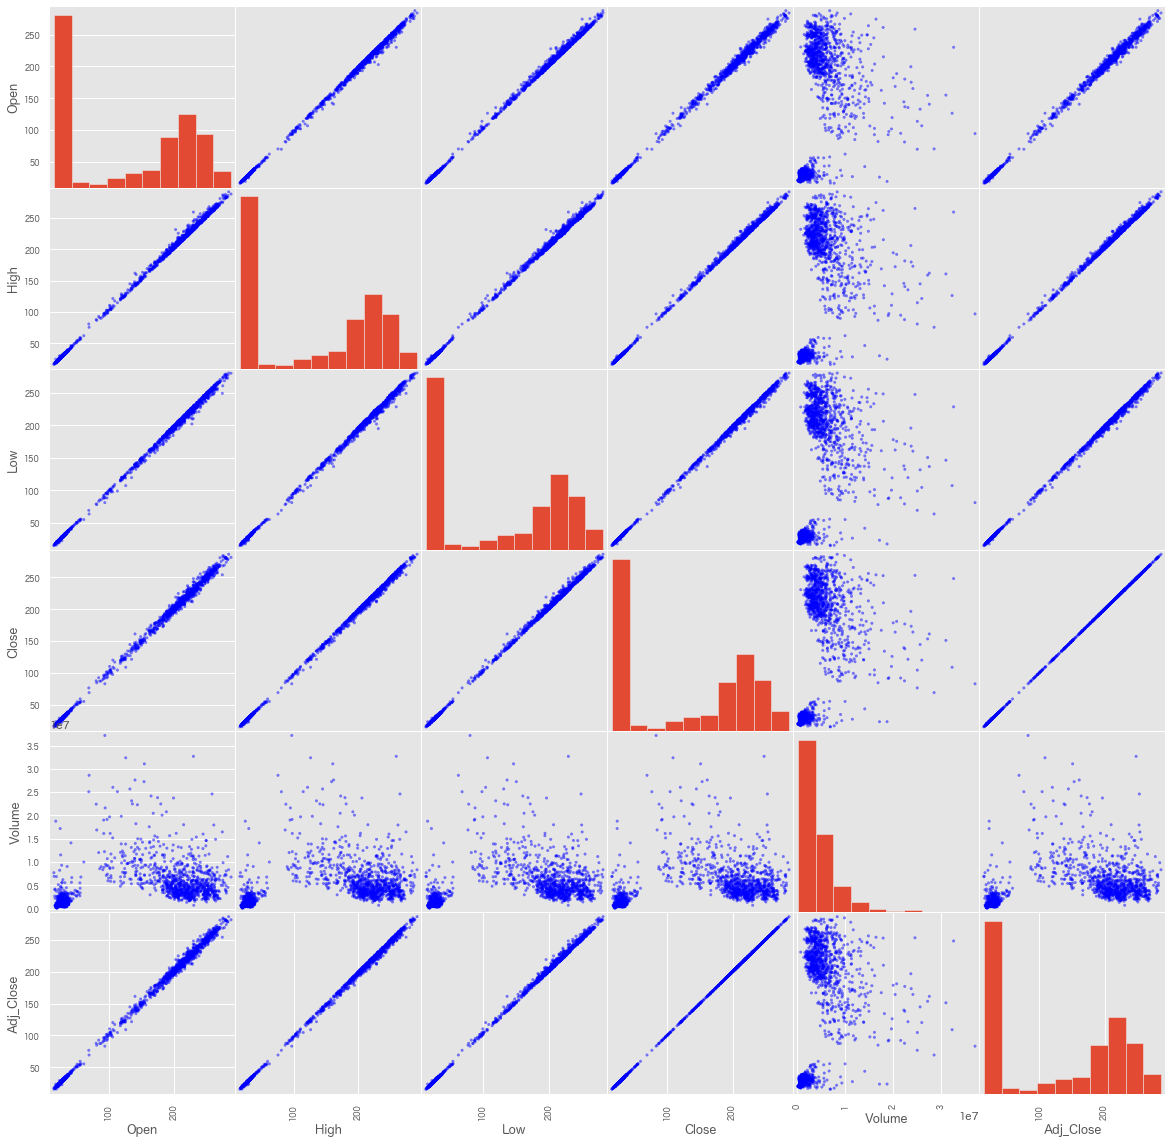

In [48]:
# 散布図行列
# 外れ値
pd.plotting.scatter_matrix(stock_df, c='blue', figsize=(20, 20))
plt.show();

線形の相関のある項目が非常に多い。  
単一の各特徴量の分布も、非常に近似している。  

# 目的変数との関係性を可視化

In [49]:
def target_relation(tgt, data):
    y_train = data[tgt]

    # ヒートマップの表示数
    k = len(data.columns) - 1
    fig = plt.figure(figsize=(20,20))

    # 各変数間の相関係数
    corrmat = data.corr()

    # リストの最大値から順にk個の要素を取得
    cols = corrmat.nlargest(k, tgt)[tgt].index

    # 全て可視化
    for i in np.arange(1, k):
        X_train = data[cols[i]]
        ax = fig.add_subplot(5,4, i)
        sns.regplot(x=X_train, y=y_train)
    
    plt.tight_layout()
    plt.show();

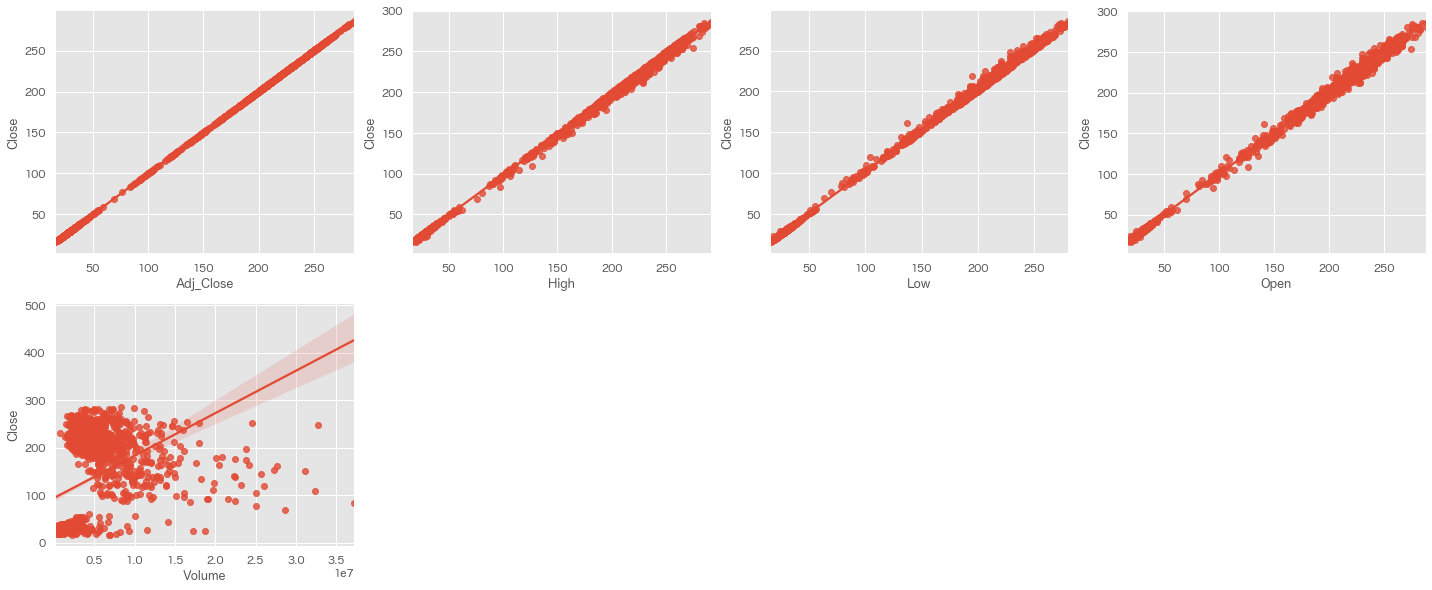

In [50]:
tgt = 'Close' # 目的変数（終わり値とした場合）
data = stock_df
target_relation(tgt, data)

Volume(取引量)は線形分離不可

# 原系列の可視化

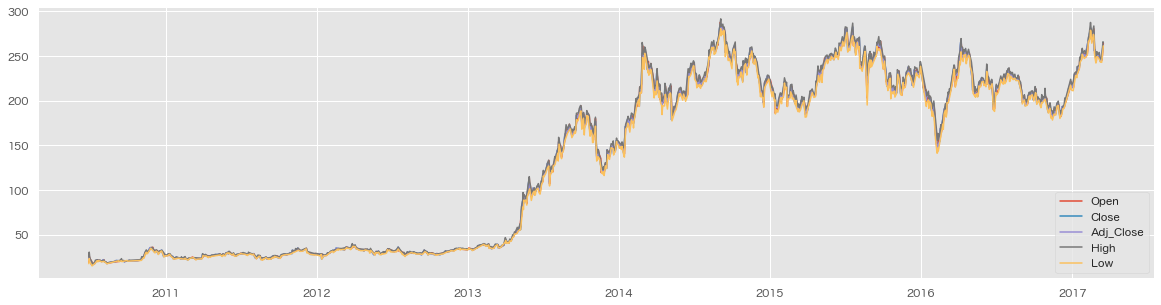

In [51]:
stock = stock_df.copy()
stock["Date"] = pd.to_datetime(stock['Date'])
stock = stock.set_index(['Date']).sort_index(ascending=True)

plt.plot(stock['Open'], label='Open')
plt.plot(stock['Close'], label='Close')
plt.plot(stock['Adj_Close'], label='Adj_Close')
plt.plot(stock['High'], label='High')
plt.plot(stock['Low'], label='Low')
plt.legend(loc='lower right')
plt.show();

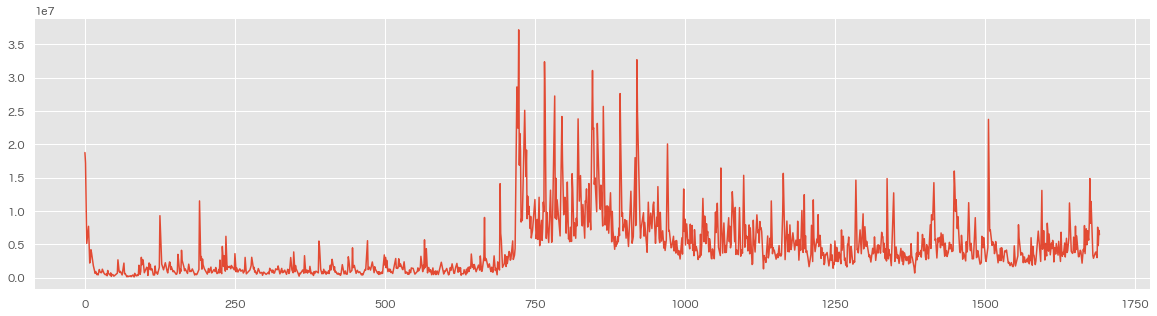

In [52]:
plt.figure(figsize=[20,5])
plt.plot(stock_df['Volume']);

Volume以外は、傾向が非常に近似していることがわかる。　　

# 定常性の確認

In [85]:
stock_df['Close'].mean()
stock_df['Close'].var()

132.42865848581542

8894.977188774867

In [86]:
stock_df['Volume'].mean()
stock_df['Volume'].var()

4270740.898345154

18455369802797.1

In [ ]:
かなりばらつきのあるデータと言える。

# データ準備

In [53]:
# Dataをインデックスに設定
time_series = stock_df.copy()
time_series["Date"] = pd.to_datetime(stock_df['Date'])
time_series = time_series.set_index(['Date']).sort_index(ascending=True)
time_series.head()
time_series.tail()

,Open,High,Low,Close,Volume,Adj_Close
Date,,,,,,
2010-06-29,19,25,18,24,18766300,24
2010-06-30,26,30,23,24,17187100,24
2010-07-01,25,26,20,22,8218800,22
2010-07-02,23,23,19,19,5139800,19
2010-07-06,20,20,16,16,6866900,16


,Open,High,Low,Close,Volume,Adj_Close
Date,,,,,,
2017-03-13,245,247,243,246,3010700,246
2017-03-14,246,258,246,258,7575500,258
2017-03-15,257,261,254,256,4816600,256
2017-03-16,262,266,259,262,7100400,262
2017-03-17,264,265,261,262,6475900,262


# ADF検定（定常性の確認）

帰無仮説：単位根課程  
対立仮設：定常過程  
P値が0.05以下の場合、帰無仮説が棄却し、定常過程を正とする。  

In [54]:
from statsmodels.tsa import stattools

def adf_test(cicle):
    features = [time_series.columns]
    adf_df = pd.DataFrame(
        [
            stattools.adfuller(time_series.resample(cicle)[features[0][0]].sum())[1],
            stattools.adfuller(time_series.resample(cicle)[features[0][1]].sum())[1],
            stattools.adfuller(time_series.resample(cicle)[features[0][2]].sum())[1],
            stattools.adfuller(time_series.resample(cicle)[features[0][3]].sum())[1],
            stattools.adfuller(time_series.resample(cicle)[features[0][4]].sum())[1],
            stattools.adfuller(time_series.resample(cicle)[features[0][5]].sum())[1],
        ],
        index=features,
        columns=['P値']
    )
    adf_df['P値'] = adf_df['P値'].round(decimals=3).astype(str)
    print(adf_df)

In [55]:
adf_test(cicle = 'D')

              P値
Open       0.811
High       0.813
Low        0.812
Close      0.812
Volume     0.031
Adj_Close  0.812


In [56]:
adf_test(cicle = 'M')

              P値
Open       0.529
High       0.533
Low         0.53
Close      0.533
Volume      0.29
Adj_Close  0.533


In [57]:
adf_test(cicle = 'Y')

              P値
Open       0.118
High       0.116
Low         0.12
Close      0.118
Volume     0.218
Adj_Close  0.118


In [58]:
def adf_test(series):
    adf_df = pd.DataFrame(
        [
            stattools.adfuller(series)[1]
        ],
        columns=['P値']
    )
    adf_df['P値'] = adf_df['P値'].round(decimals=3).astype(str)
    print(adf_df)

In [59]:
adf_test(series=time_series['Close'])

      P値
0  0.815


In [60]:
adf_test(series=time_series['Close'])

      P値
0  0.815


結果、定常性なしと判断される。

# 前処理

## 差分変換

差分を取る（差分の増減のみを拾う）ことで、トレンドを除去し、平均における非定常性を解消する。  
全項目の特徴が似ているため、以下、Close（終値）のみに（一旦）着目して変換していく。　　

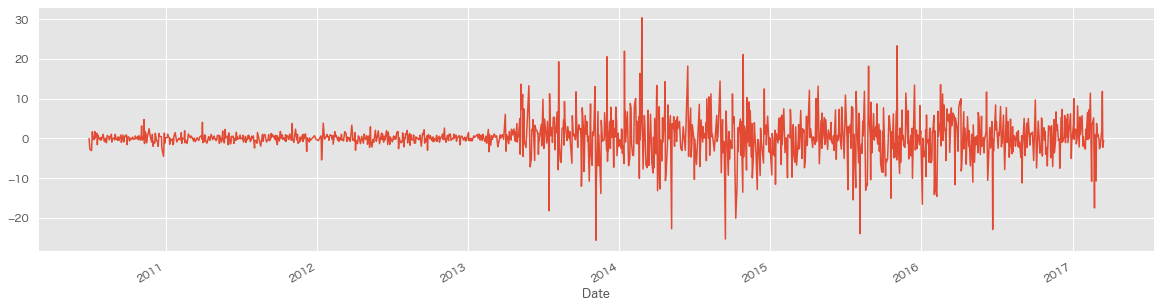

In [61]:
# 差分変換後のプロット
time_proc = time_series.copy()
Passengers_diff_c = time_proc["Close"].diff(periods = 1)
Passengers_diff_c.plot(figsize=[20,5]);

In [88]:
Passengers_diff_c.mean()
Passengers_diff_c.var()

0.14051448905972796

19.280544728402738

平均が０にかなり近づいたことがわかります。  

## 対数変換

トレンドに比例したばらつきの増加を解消（なめらかに）する。

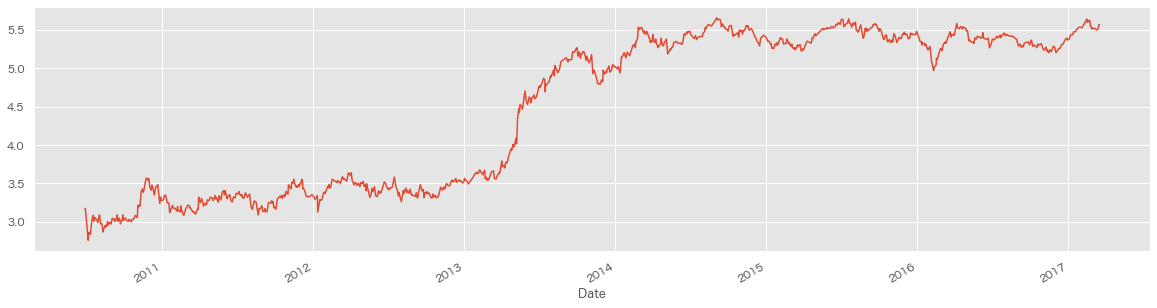

In [62]:
Passengers_log_c = np.log(time_proc["Close"])
Passengers_log_c.plot(figsize=[20,5]);

In [89]:
Passengers_log_c.mean()
Passengers_log_c.var()

4.48285833956542

0.9894592908040513

平均は0から多少離れていますが、分散はかなりなくなったことがわかります。

## 対数差分変換

対数変換によりなめらかにした推移の差分を取得した。  
周期性が残っているものの、定常性の条件のうち、平均と分散は（多少）解消した。

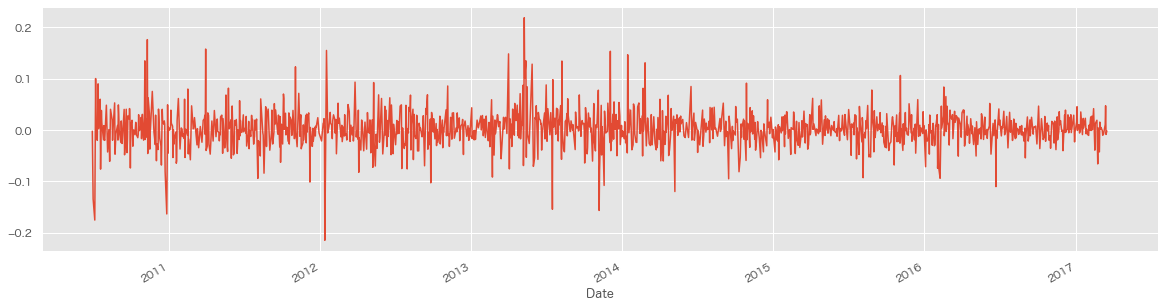

In [63]:
Passengers_log_diff_c = Passengers_log_c.diff(periods = 1)
Passengers_log_diff_c.plot(figsize=[20,5]);

In [90]:
Passengers_log_diff_c.mean()
Passengers_log_diff_c.var()

0.0014151238107781069

0.001069792377059396

平均と分散がかなり小さくなり、データのばらつきが解消されたことがわかります。

## 季節差分変換

年間の差分を取り、周期性を取り除いた。  
季節周期がなくなり、前年差が残る。  

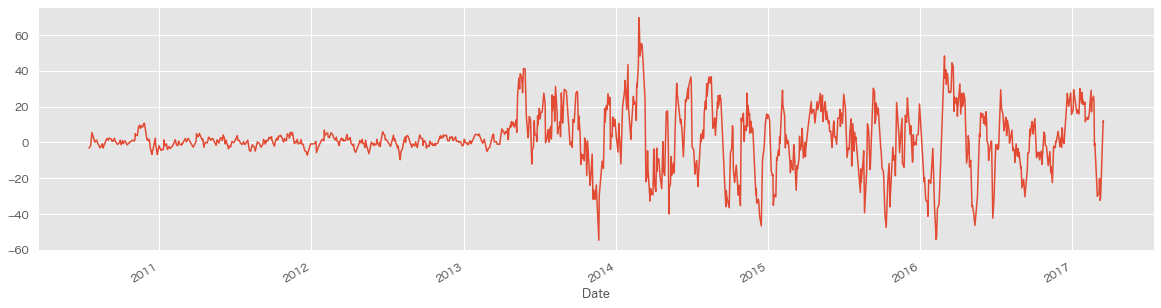

In [64]:
Passengers_sdiff_c = time_proc["Close"].diff(periods = 12) # 季節：periods = 12
Passengers_sdiff_c.plot(figsize=[20,5]);

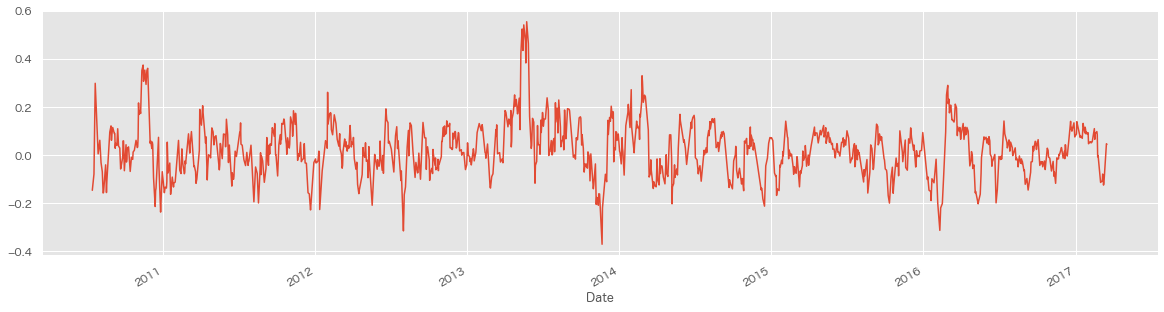

In [65]:
Passengers_log_sdiff_c = Passengers_log_c.diff(periods = 12) # 季節：periods = 12
Passengers_log_sdiff_c.plot(figsize=[20,5]);

対数差分変換の結果に対して、季節差分を取ることでより周期性を取り除けた。　　

## ラグ1の差分を取る

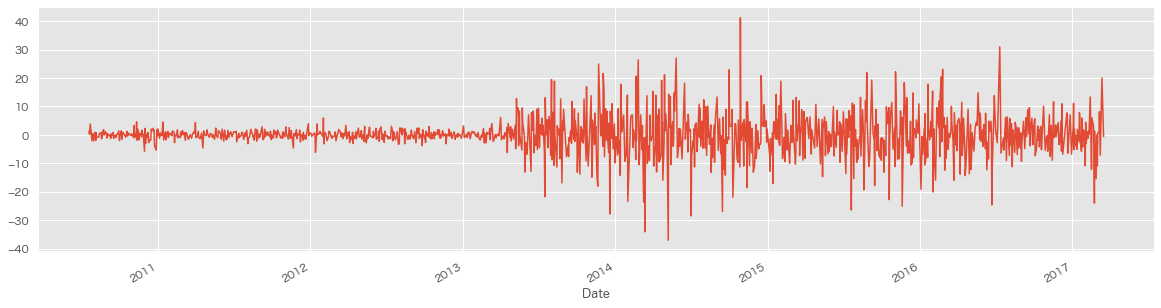

In [66]:
Passengers_sdiff2_c = Passengers_sdiff_c.diff()
Passengers_sdiff2_c.plot(figsize=[20,5]);

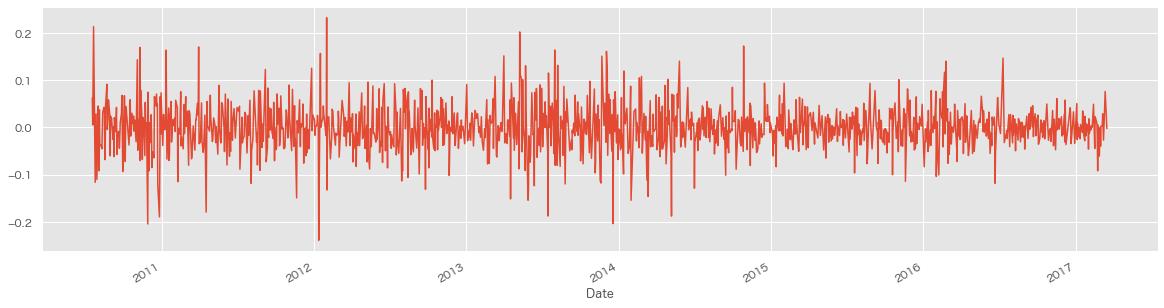

In [67]:
Passengers_sdiff2_c = Passengers_log_sdiff_c.diff()
Passengers_sdiff2_c.plot(figsize=[20,5]);

In [91]:
Passengers_sdiff2_c.mean()
Passengers_sdiff2_c.var()

0.00011383107811750517

0.002114027868931279

対数差分変換より平均がさらに0に近づきました。分散は微妙にこちらの方が高い値です。

どのような性質をもつ系列であれば、差分変換が適切か  
単位根過程：「原系列が非定常であり、その差分系列が定常であるような時系列」、つまり「和分過程」であれば適切  

# 周期生の分析

## 成分分解（季節調整）

Trend：周期の長さで移動平均を求め、トレンド成分を求める  
Seasonal：トレンド除去後の時系列から季節性の成分を求める  
Resid：残差を求める  

In [68]:
# 成分分解（季節調整）
import statsmodels.api as sm

# 表示サイズ調整
plt.rcParams["figure.figsize"] = [20,10]
plt.rcParams["font.size"] = 15

# 原系列、傾向（トレンド）、周期変動（季節性）、不規則変動（残差）
def plt_seasonal_decompose(df, col_name, period):
    res = sm.tsa.seasonal_decompose(df[col_name], period=period)
    fig = res.plot()
    plt.show()

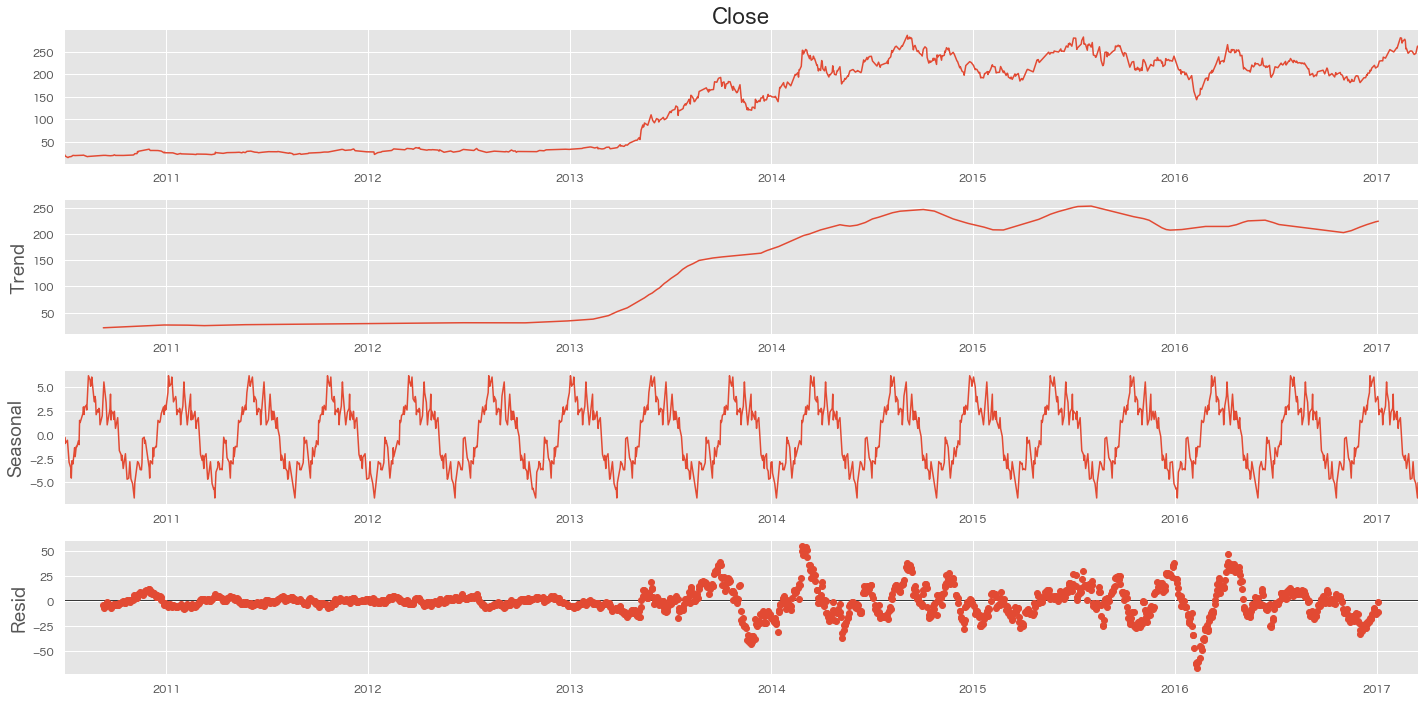

In [69]:
# 原系列をインプットして確認
plt_seasonal_decompose(time_series, col_name='Close', period=100)

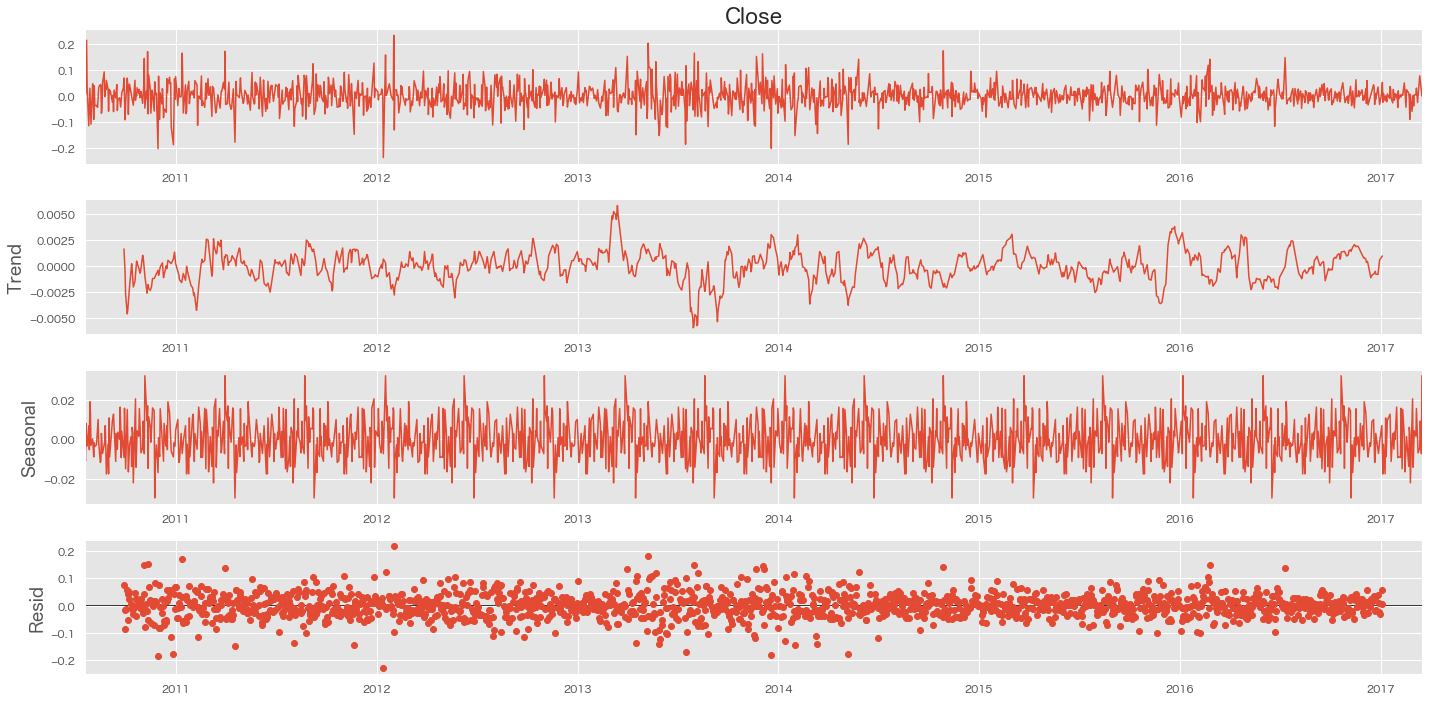

In [70]:
# 変換済みデータの欠損の削除
Passengers_sdiff2_c2 = Passengers_sdiff2_c.dropna()

# 成分分解（季節調整）
res = sm.tsa.seasonal_decompose(Passengers_sdiff2_c2, period=100)
fig = res.plot()
plt.show()

インプット（原系列）を変えたことで、傾向変動、季節変動、不規則変動の見え方も大きく変わってきている。　　

## 移動平均

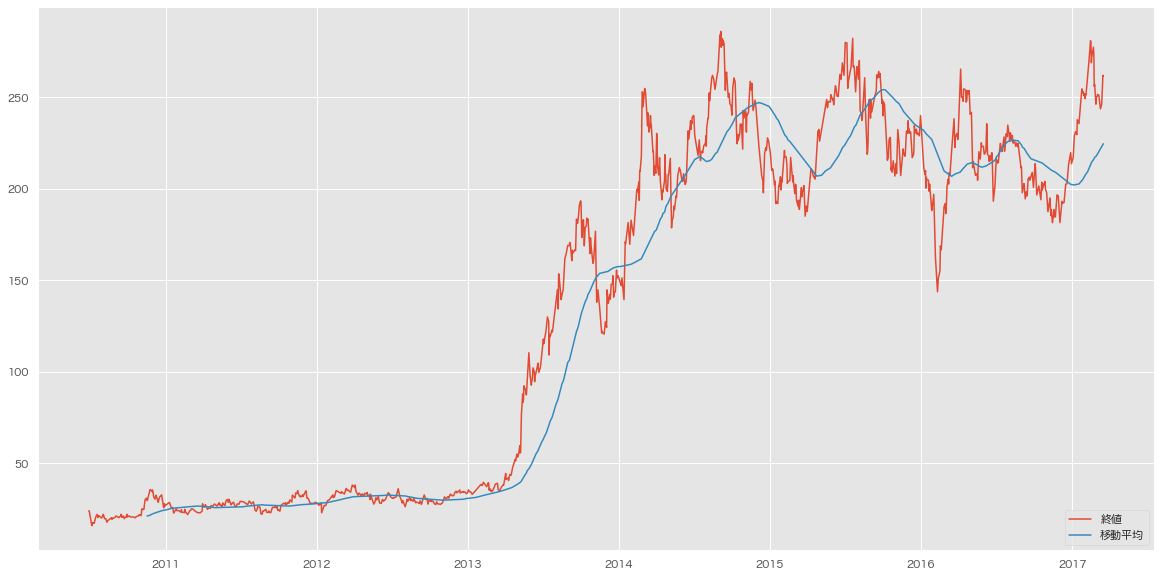

In [71]:
stock = stock_df.copy()
stock["Date"] = pd.to_datetime(stock['Date'])
stock = stock.set_index(['Date']).sort_index(ascending=True)

# 移動平均
stock['Close_move_mean'] = stock['Close'].rolling(100).mean().round(1)

plt.plot(stock['Close'], label='終値')
plt.plot(stock['Close_move_mean'], label='移動平均')
plt.legend(loc='lower right')
plt.show();

## コレログラム

In [72]:
# 表示サイズ調整
plt.rcParams["figure.figsize"] = [20,2]
plt.rcParams["font.size"] = 10

# コレログラム
def correlogram(cicle, lags, df, feature):
    sm.graphics.tsa.plot_acf(df.resample(cicle)[feature].sum(), title=feature, lags=lags)
    
def correlogram2(cicle, lags, series, feature):
    sm.graphics.tsa.plot_acf(series.resample(cicle).sum(), title=feature, lags=lags)

### 原系列で確認

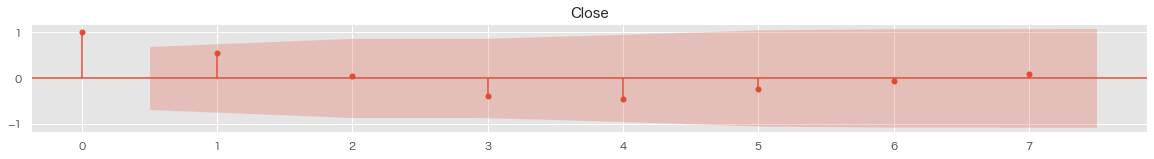

In [73]:
# まずは原系列をインプットして確認
correlogram(cicle='Y', lags='7', df=time_series, feature='Close')

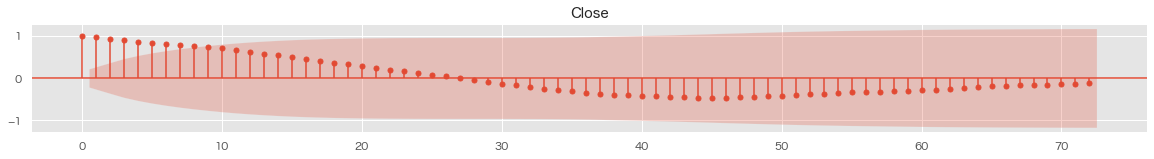

In [74]:
correlogram(cicle='M', lags=str(12*6), df=time_series, feature='Close')

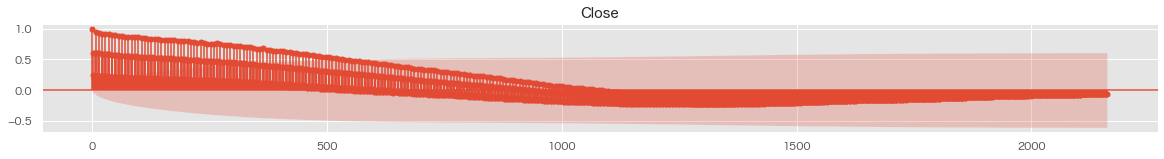

In [75]:
correlogram(cicle='D', lags=str(30*12*6), df=time_series, feature='Close')

### 変換済みデータで確認

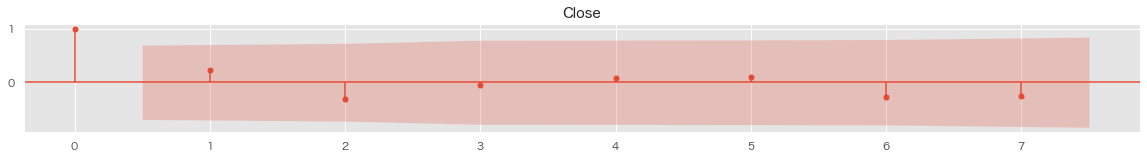

In [76]:
# 変換済みのデータをインプット
correlogram2(cicle='Y', lags='7', series=Passengers_sdiff2_c2, feature='Close')

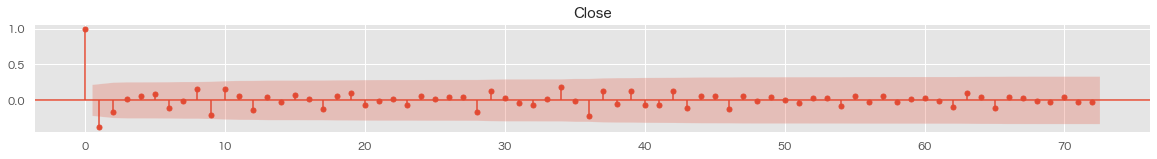

In [77]:
correlogram2(cicle='M', lags=str(12*6), series=Passengers_sdiff2_c2, feature='Close')

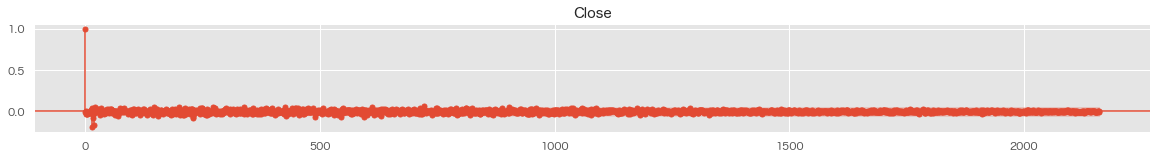

In [78]:
correlogram2(cicle='D', lags=str(30*12*6), series=Passengers_sdiff2_c2, feature='Close')

あまり大きな変動はなく、（際立つような）周期性はないものと思われる。

# 前処理後のデータで再確認

In [79]:
# ADF検定
adf_df = pd.DataFrame(
    [
        stattools.adfuller(Passengers_sdiff2_c2.resample('Y').sum())[1]
    ],
    columns=['P値']
)
adf_df['P値'] = adf_df['P値'].round(decimals=3).astype(str)
print(adf_df)

      P値
0  0.534


変換前よりも定常過程に近づいたが、変換後も定常性とはなりえなかった。  
定常性となりえなかった要因を取り除く必要がある。  
そのために、まずはなぜ定常性がないのかを考察する必要がある。  
また、今回は特徴量が非常にシンプルなデータセットを用いているが、本来はそれ以外の特徴量を追加・生成するなどの対応も必要と思われる。  
もしくは「定常・否定常」に左右されない分析手法を採用する、などの検討を行う。  

# 時間軸を絞り解析

検定の結果、定常性ありとは判断できなかったが、念の為、解析を続行する。  
以下では、時間軸を絞り解析する。  

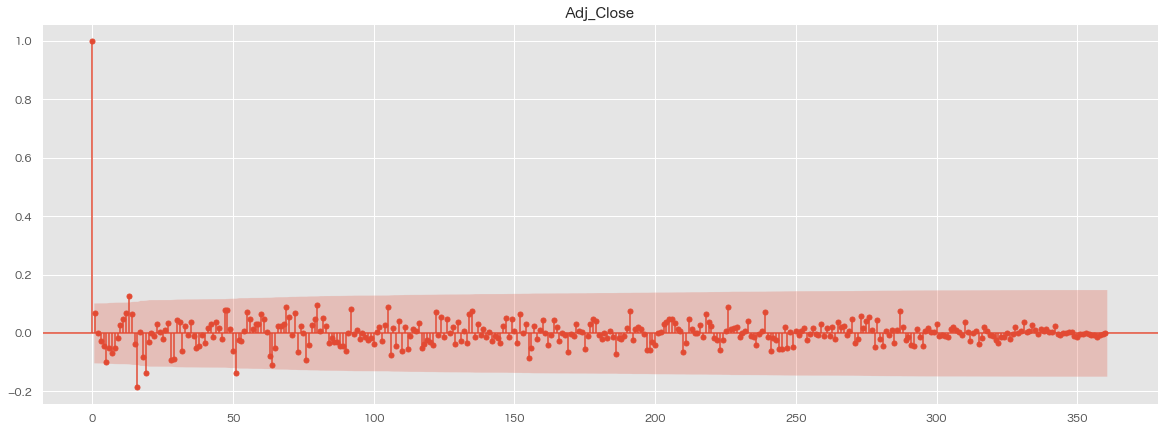

In [80]:
plt.rcParams["figure.figsize"] = [20,7]

# 2015年に絞る
Passengers_sdiff2_c2_2015 = Passengers_sdiff2_c2[ Passengers_sdiff2_c2.index.astype(str).str[:4] == '2015' ].copy()
sm.graphics.tsa.plot_acf(Passengers_sdiff2_c2_2015.resample('D').sum(), title='Adj_Close', lags=str(30*12));

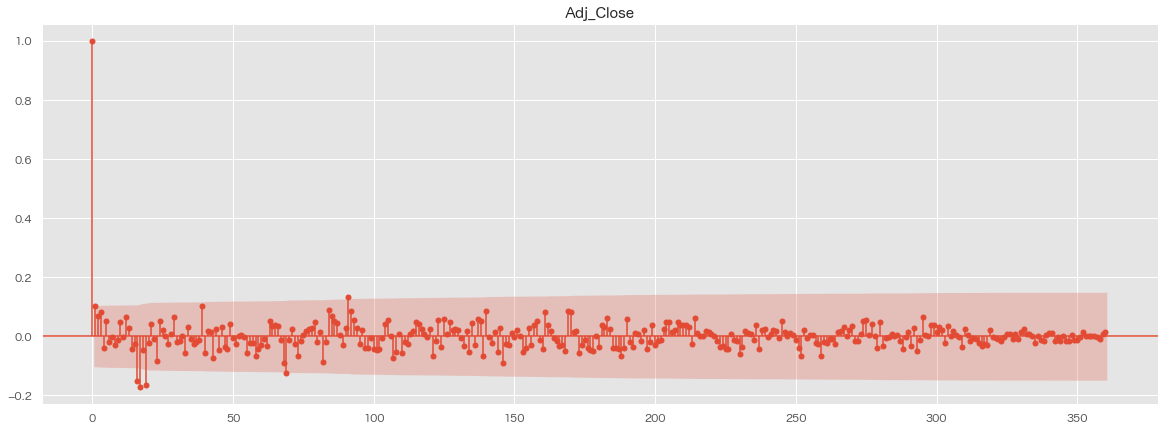

In [81]:
# 2016年に絞る
Passengers_sdiff2_c2_2016 = Passengers_sdiff2_c2[ Passengers_sdiff2_c2.index.astype(str).str[:4] == '2016' ].copy()
sm.graphics.tsa.plot_acf(Passengers_sdiff2_c2_2016.resample('D').sum(), title='Adj_Close', lags=str(30*12));

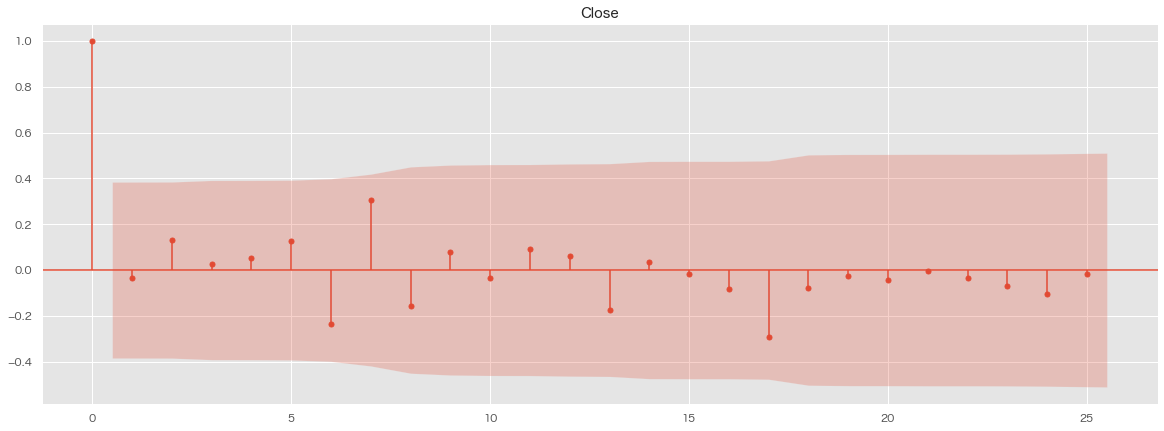

In [82]:
# 2016年の1月に絞る
Passengers_sdiff2_c2_2016_1 = Passengers_sdiff2_c2[ Passengers_sdiff2_c2.index.astype(str).str[:7] == '2016-01' ].copy()
sm.graphics.tsa.plot_acf(Passengers_sdiff2_c2_2016_1.resample('D').sum(), title='Close', lags=str(25));

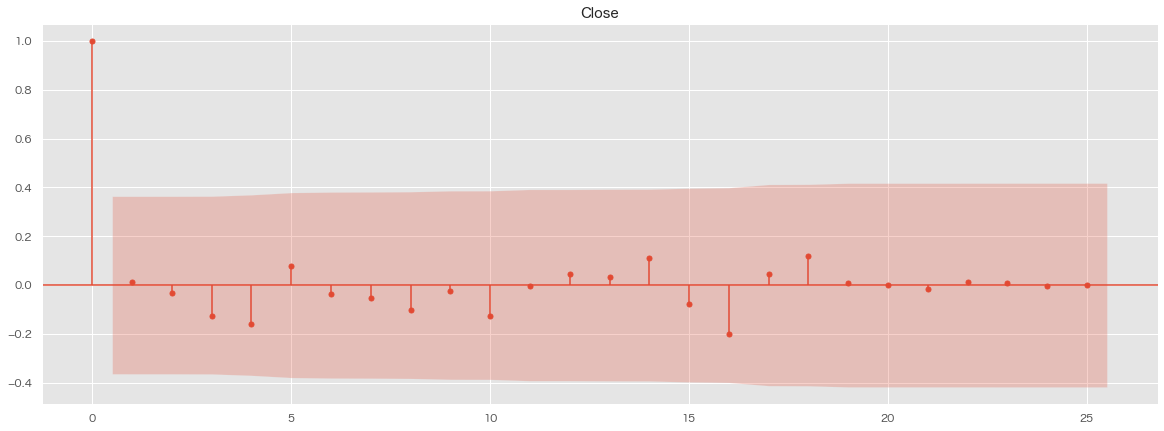

In [83]:
# 2016年の7月に絞る
Passengers_sdiff2_c2_2016_7 = Passengers_sdiff2_c2[ Passengers_sdiff2_c2.index.astype(str).str[:7] == '2016-07' ].copy()
sm.graphics.tsa.plot_acf(Passengers_sdiff2_c2_2016_7.resample('D').sum(), title='Close', lags=str(25));

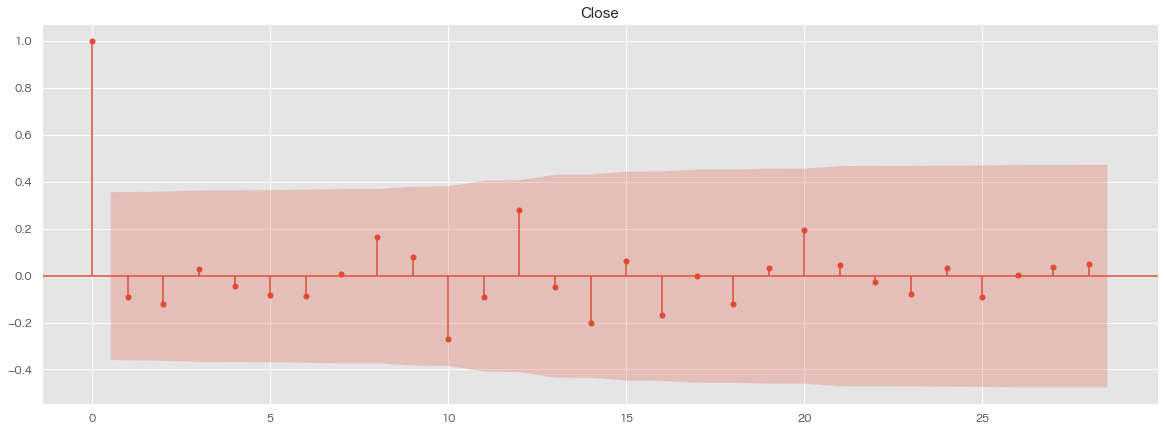

In [84]:
# 2016年の12月に絞る
Passengers_sdiff2_c2_2016_12 = Passengers_sdiff2_c2[ Passengers_sdiff2_c2.index.astype(str).str[:7] == '2016-12' ].copy()
sm.graphics.tsa.plot_acf(Passengers_sdiff2_c2_2016_12.resample('D').sum(), title='Close', lags=str(28));

月毎に微妙な変化が見られる。